EDA on Trade Data

Trade data was pulled and merged from an existing personally maintained Postgres DB. I changed the existing webscraper to collect many more trades at the same time, but used the existing DB structure for simplicity. I then used this Django command to combine and output it:

```{python}
    @transaction.atomic
    def handle(self, *args, **options):
        filename = "joined_data.csv"
        fields = [
            "trade_id",
            "trade_date",
            "action",
            "amount",
            "flagged",
            "price_at_trade",
            "current_price",
            "member_name",
            "member_party",
            "member_state",
            "member_chamber",
            "stock_ticker",
            "stock_name",
            "sector_code",
            "sector_name",
            "committee_names",
        ]

        with open(filename, "w", newline="", encoding="utf-8") as f:
            writer = csv.writer(f)
            writer.writerow(fields)

            trades = Trade.objects.select_related(
                "member", "stock__sector"
            ).prefetch_related("member__committeemembership_set__committee")

            for trade in trades.iterator(chunk_size=2000):
                member = trade.member
                stock = trade.stock
                sector = stock.sector

                committees = [
                    m.committee.committee_name
                    for m in member.committeemembership_set.all()
                ]
                committee_names = ", ".join(committees) if committees else ""

                writer.writerow(
                    [
                        trade.id,
                        trade.date,
                        trade.get_type_display(),
                        trade.amount,
                        trade.flagged,
                        trade.price_at_trade,
                        trade.current_price,
                        member.full_name,
                        member.get_party_display(),
                        member.state,
                        member.get_chamber_display(),
                        stock.ticker,
                        stock.name,
                        sector.sector_code,
                        sector.sector_name,
                        committee_names,
                    ]
                )

        self.stdout.write(
            self.style.SUCCESS(f"Exported {Trade.objects.count()} trades to {filename}")
        )

```


In [58]:
import pandas as pd
import matplotlib.pyplot as plt

Import trade data and display top few columns. Interestingly, Tim Moore bought several thousand dollars worth of Krispy Kreme stock. Nice! Krispy Kreme is also listed as a "Consumer Staple" by the NASDAQ instead of "Consumer Discretionary". I heartily agree.

In [59]:
df = pd.read_csv('trade_data.csv')
df.head()

,trade_id,trade_date,action,amount,flagged,price_at_trade,current_price,member_name,member_party,member_state,member_chamber,stock_ticker,stock_name,sector_code,sector_name,committee_names
0,20003790034,2025-08-11,b,32500,False,20.65,39.99,Tim Moore,Republican,NC,House of Representatives,INTC,Intel Corporation Common Stock,45,Technology,"Budget, Financial Services"
1,20003790035,2025-08-01,b,8000,False,3.44,3.59,Tim Moore,Republican,NC,House of Representatives,DNUT,Krispy Kreme Inc. Common Stock,30,Consumer Staples,"Budget, Financial Services"
2,20003790036,2025-08-04,b,8000,False,3.65,3.59,Tim Moore,Republican,NC,House of Representatives,DNUT,Krispy Kreme Inc. Common Stock,30,Consumer Staples,"Budget, Financial Services"
3,20003790037,2025-08-01,b,8000,False,237.77,341.56,Tim Moore,Republican,NC,House of Representatives,UNH,UnitedHealth Group Incorporated Common Stock (DE),35,Healthcare,"Budget, Financial Services"
4,20003790038,2025-08-08,b,32500,False,250.89,341.56,Tim Moore,Republican,NC,House of Representatives,UNH,UnitedHealth Group Incorporated Common Stock (DE),35,Healthcare,"Budget, Financial Services"


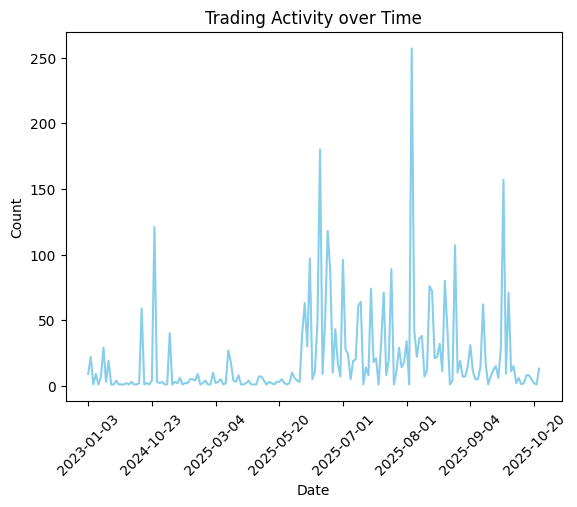

In [60]:
counts = df["trade_date"].value_counts().sort_index()

counts.plot(kind="line", color="skyblue")

plt.title("Trading Activity over Time")
plt.xlabel("Date")
plt.xticks(rotation=45)
plt.ylabel("Count")
plt.show()


If we separate out by purchases and sales, we can see when members of Congress were buying and selling more

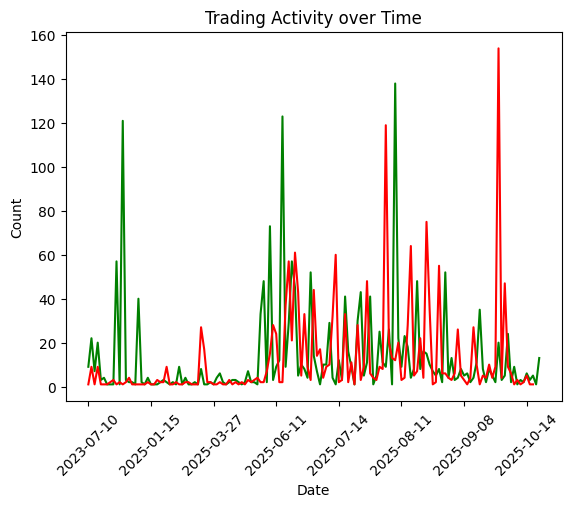

In [61]:
buy_trades = df[df['action'] == 'b']

buy_counts = buy_trades["trade_date"].value_counts().sort_index()

buy_counts.plot(kind="line", color="green")

sell_trades = df[df['action'] == 's']

sell_counts = sell_trades["trade_date"].value_counts().sort_index()

sell_counts.plot(kind="line", color="red")


plt.title("Trading Activity over Time")
plt.xlabel("Date")
plt.xticks(rotation=45)
plt.ylabel("Count")
plt.show()

It seems there are some days with massive spikes in either purchases or sales. Let's create a histogram to find the top 10-15 most active days.

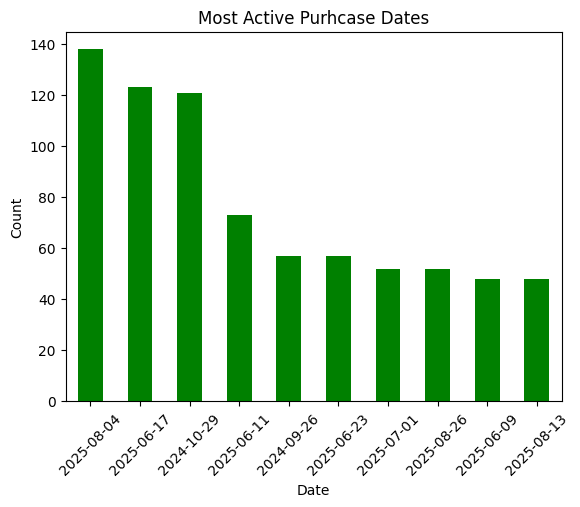

In [62]:
buy_counts = buy_trades["trade_date"].value_counts().sort_values(ascending=False).head(10)
buy_counts.plot(kind="bar", color="green")
plt.title("Most Active Purhcase Dates")
plt.xlabel("Date")
plt.xticks(rotation=45)
plt.ylabel("Count")
plt.show()

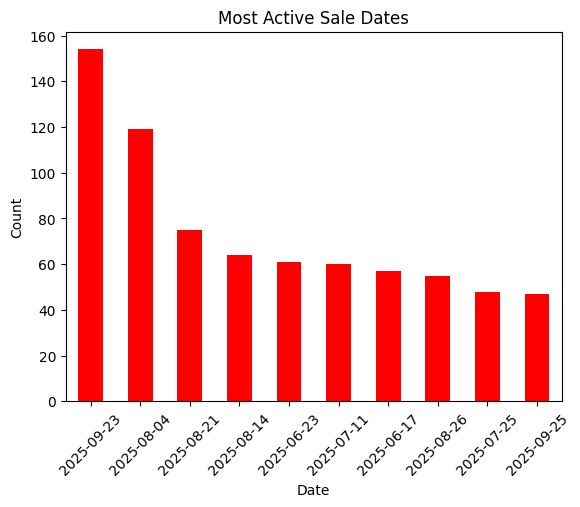

In [63]:
sell_counts = sell_trades["trade_date"].value_counts().sort_values(ascending=False).head(10)
sell_counts.plot(kind="bar", color="red")
plt.title("Most Active Sale Dates")
plt.xlabel("Date")
plt.xticks(rotation=45)
plt.ylabel("Count")
plt.show()

We can find the average difference between purchase price and current price to get a general sense of how these trades are performing.

In [64]:
buy_trades = df[df['action'] == 'b']
avg_diff = (buy_trades['current_price'] - buy_trades['price_at_trade']).mean()

print(f"Average price difference for buys: {avg_diff:.2f}")

Average price difference for buys: 12.43


Similar code for average difference between sale price and current price

In [65]:
sell_trades = df[df['action'] == 's']
avg_diff = (sell_trades['current_price'] - sell_trades['price_at_trade']).mean()
print(f"Average price difference for sales: {avg_diff:.2f}")

Average price difference for sales: 8.34


Let's see who the most active traders are by creating a histogram showing the top 10 most active

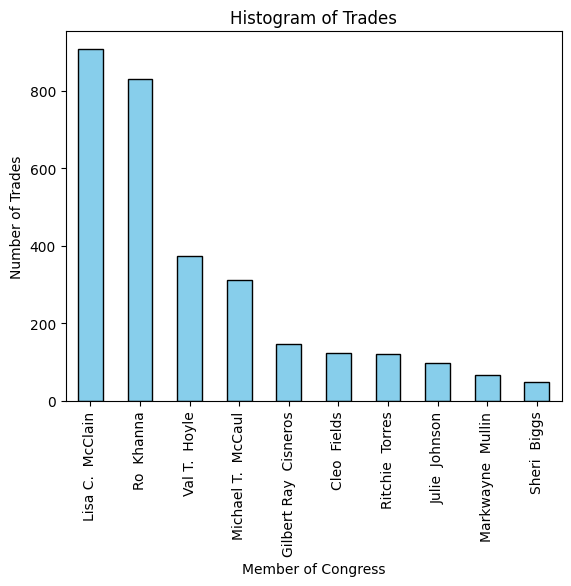

In [66]:
counts = df["member_name"].value_counts().nlargest(10)

counts.plot(kind="bar", color="skyblue", edgecolor="black")

plt.title("Histogram of Trades")
plt.xlabel("Member of Congress")
plt.ylabel("Number of Trades")
plt.show()


These people have the most overall trades. We can filter by flagged trades to see has the most flagged and suspicious trades.

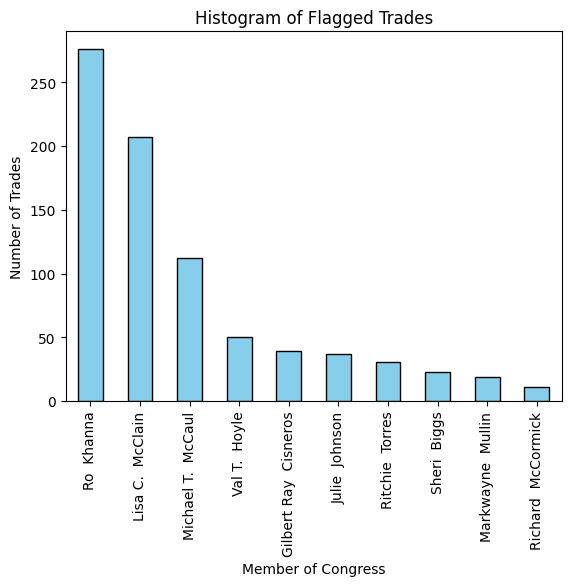

In [67]:
flagged_df = df[df['flagged'] == True]

counts = flagged_df["member_name"].value_counts().nlargest(10)

counts.plot(kind="bar", color="skyblue", edgecolor="black")

plt.title("Histogram of Flagged Trades")
plt.xlabel("Member of Congress")
plt.ylabel("Number of Trades")
plt.show()

We can also check which GICS sectors are being bought and sold the most. Since they should be roughly equal over the course of the dataset, I'm going to only show for trades in the last 6 months

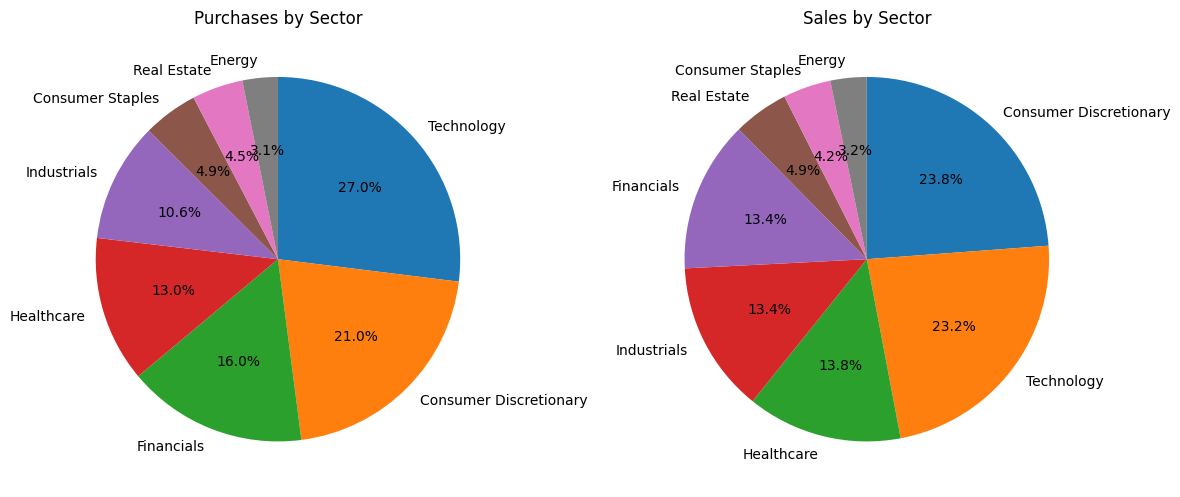

In [68]:
df_range = df[
    (df['trade_date'] >= '2025-05-01') 
]


buy_counts = df_range[df_range['action'] == 'b']['sector_name'].value_counts().head(8)
sell_counts = df_range[df_range['action'] == 's']['sector_name'].value_counts().head(8)

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

axes[0].pie(
    buy_counts,
    labels=buy_counts.index,
    autopct='%1.1f%%',
    startangle=90,
    counterclock=False
)
axes[0].set_title('Purchases by Sector')

axes[1].pie(
    sell_counts,
    labels=sell_counts.index,
    autopct='%1.1f%%',
    startangle=90,
    counterclock=False
)
axes[1].set_title('Sales by Sector')

plt.tight_layout()
plt.show()


The above pie charts show there is greater investment in technology and congressmen are selling stocks of companies in the consumer discretionary sector. With the recent advances in AI, it makes sense that most of the investments would be in the tech sector. As cost of living and inflation increases, consumer discretionary spending will decrease, decreasing earnings for those companies. However, this data only shows the **amount** of trades, not the trade volume. Let's group by volume as well. 

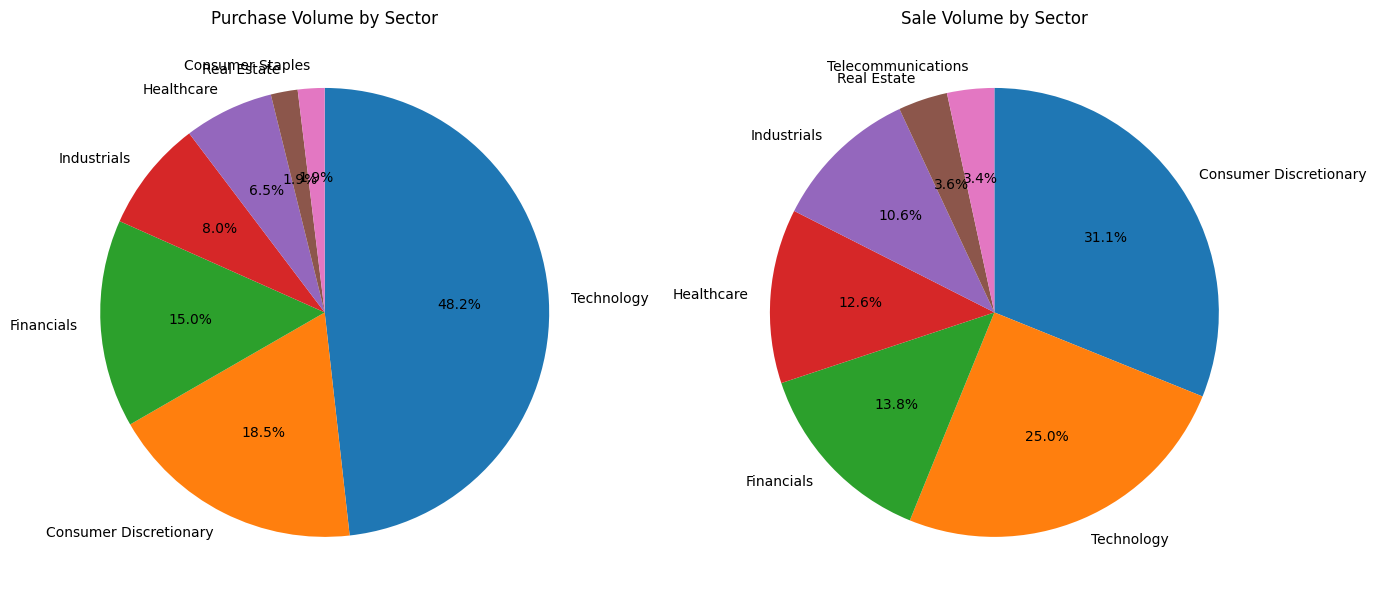

In [69]:
buy_amounts = df_range.loc[df_range['action'] == 'b'].groupby('sector_name')['amount'].sum().sort_values(ascending=False).head(7)
sell_amounts = df_range.loc[df_range['action'] == 's'].groupby('sector_name')['amount'].sum().sort_values(ascending=False).head(7)

fig, axes = plt.subplots(1, 2, figsize=(14, 7))

axes[0].pie(buy_amounts, labels=buy_amounts.index, autopct='%1.1f%%',
            startangle=90, counterclock=False)
axes[1].pie(sell_amounts, labels=sell_amounts.index, autopct='%1.1f%%',
            startangle=90, counterclock=False)
axes[0].set_title('Purchase Volume by Sector')
axes[1].set_title('Sale Volume by Sector')

plt.tight_layout()
plt.show()

The difference is even more pronounced when viewed this way. There is heavy investment in the technology sector, while stocks in the consumer discretionary sector are being sold at nearly twice the rate they're being bought.